## Training with TELSEM emissivity

Using windsat grid

In [52]:
import matplotlib.pyplot as plt
import pickle
import xarray as xr
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

import cartopy.crs as ccrs


from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
import sys
sys.path.append("../../")

from src.processing import windsat_datacube, model_preprocess, create_landmask
from src.model import transform_batch, xy_split, plot_history


In [53]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ascds= model_preprocess(ds)
ascds

<xarray.Dataset> Size: 784MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [54]:
# open the datasets with dask
telsem_ds = xr.open_mfdataset(
    paths = "../../data/processed/WinsatEmiss/*.nc",
    engine="netcdf4",
    concat_dim="month",
    combine="nested"
)
telsem_ds

<xarray.Dataset> Size: 2GB
Dimensions:         (latitude_grid: 720, longitude_grid: 1440, month: 12)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
Dimensions without coordinates: latitude_grid, longitude_grid, month
Data variables: (12/16)
    Emis19V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis19H         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis22V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37H         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis85V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    VarEmis37V      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    VarEmis37H      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    VarEmis85V      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    VarEmis85H      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Surface_class1  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Surface_class2  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

#### TODO: 
We only need V and H emissivities for chanels 18.5(19) GHz and 37 GHz, select those variables.

Maybe later we can esperiment with surface classification, lets try to create a single model for all land pixels as a starting point.


In [55]:
# Preprocessing of TELSEM atlas:
telsem_ds = xr.open_mfdataset(
    paths = "../../data/processed/WinsatEmiss/*.nc",
    engine="netcdf4",
    concat_dim="month",
    combine="nested"
)

# Select only the desired data variables:

d_vars = [
    "Emis19V",
    "Emis19H",
    "Emis37V",
    "Emis37H",
]

telsem_ds = telsem_ds[d_vars]

#roll the longitude to align the data
telsem_ds = telsem_ds.roll(
    {
        "longitude_grid" : 4 * 180
    }
)

landmask = create_landmask(lat = telsem_ds.lat.values, lon= telsem_ds.lon.values)
telsem_ds["landmask"] = (("latitude_grid","longitude_grid"),landmask.values)

telsem_ds = telsem_ds.where(telsem_ds.landmask == 0)
telsem_ds = telsem_ds.drop_vars("landmask")
telsem_ds = telsem_ds.reset_coords()

telsem_ds

<xarray.Dataset> Size: 398MB
Dimensions:  (month: 12, latitude_grid: 720, longitude_grid: 1440)
Dimensions without coordinates: month, latitude_grid, longitude_grid
Data variables:
    Emis19V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis19H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat      (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon      (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [56]:
# Create an atlas dataframe with all the months:
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   0  0.838461  0.642331  0.850453  0.687476   
              1                   0  0.838612  0.642670  0.850646  0.687777   
              2                   0  0.838762  0.643009  0.850838  0.688078   
              3                   0  0.838912  0.643348  0.851031  0.688379   
              4                   0  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                11  0.929797  0.854530  0.850951  0.786876   
              610                11  0.929314  0.854520  0.845948  0.783754   
              611                11  0.928832  0.854509  0.840944  0.780632   
              612                11  0.929997  0.855679  0.836587  0.777149   
694           589                11  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [57]:
[print(dv) for dv in ascds.data_vars.keys()]

surtep_ERA5
lat
lon
tbtoa_18Ghz_V
tbtoa_18Ghz_H
tbtoa_37Ghz_V
tbtoa_37Ghz_H
time_18Ghz
time_37Ghz


[None, None, None, None, None, None, None, None, None]

In [58]:
# simillarly with windsat data

# Select the necessary dvars
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

ascds = ascds[d_vars]

asc_df = ascds.to_dataframe().dropna().reset_index("day_number")
asc_df

day_number  surtep_ERA5     lat     lon  \
latitude_grid longitude_grid                                            
147           1014                     1   275.894440 -53.125  73.625   
161           995                      1   276.849609 -49.625  68.875   
              998                      1   277.820099 -49.625  69.625   
              999                      1   278.050476 -49.625  69.875   
              1000                     1   277.954346 -49.625  70.125   
...                                  ...          ...     ...     ...   
642           808                     21   276.515686  70.625  22.125   
              809                     21   275.758698  70.625  22.375   
673           766                     21   275.418823  78.375  11.625   
              767                     21   275.177582  78.375  11.875   
675           762                     21   275.711639  78.875  10.625   

                              tbtoa_18Ghz_V  tbtoa_18Ghz_H  tbtoa_37Ghz_V  \
latitude_grid longitude_grid                                                
147           1014               194.885010     127.485001     215.657501   
161           995                211.529999     159.434998     230.509995   
              998                218.139999     172.832489     234.354996   
              999                217.937500     172.014999     234.285004   
              1000               213.382492     163.179993     231.119995   
...                                     ...            ...            ...   
642           808                202.862488     140.917496     215.862503   
              809                208.297485     151.820007     217.259995   
673           766                196.614990     127.227493     208.505005   
              767                196.882492     127.707497     208.345001   
675           762                193.684998     122.047501     209.669998   

                              tbtoa_37Ghz_H  
latitude_grid longitude_grid                 
147           1014               163.107498  
161           995                191.927490  
              998                200.334991  
              999                199.912506  
              1000               193.644989  
...                                     ...  
642           808                169.722504  
              809                175.607498  
673           766                153.690002  
              767                153.547501  
675           762                153.427490  

[571966 rows x 8 columns]

In [59]:
# Map the day of the year (day_number) into the month:
day_mapping = []
days_in_months = [31,29,31,30,31,30,31,31,30,31,30,31]

for i, n in enumerate(days_in_months):
    to_add = [i +1] * n
    day_mapping.extend(to_add)
len(day_mapping)


asc_df["month"] = asc_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
asc_df = asc_df.drop(columns="day_number")

asc_df

surtep_ERA5     lat     lon  tbtoa_18Ghz_V  \
latitude_grid longitude_grid                                               
147           1014             275.894440 -53.125  73.625     194.885010   
161           995              276.849609 -49.625  68.875     211.529999   
              998              277.820099 -49.625  69.625     218.139999   
              999              278.050476 -49.625  69.875     217.937500   
              1000             277.954346 -49.625  70.125     213.382492   
...                                   ...     ...     ...            ...   
642           808              276.515686  70.625  22.125     202.862488   
              809              275.758698  70.625  22.375     208.297485   
673           766              275.418823  78.375  11.625     196.614990   
              767              275.177582  78.375  11.875     196.882492   
675           762              275.711639  78.875  10.625     193.684998   

                              tbtoa_18Ghz_H  tbtoa_37Ghz_V  tbtoa_37Ghz_H  \
latitude_grid longitude_grid                                                
147           1014               127.485001     215.657501     163.107498   
161           995                159.434998     230.509995     191.927490   
              998                172.832489     234.354996     200.334991   
              999                172.014999     234.285004     199.912506   
              1000               163.179993     231.119995     193.644989   
...                                     ...            ...            ...   
642           808                140.917496     215.862503     169.722504   
              809                151.820007     217.259995     175.607498   
673           766                127.227493     208.505005     153.690002   
              767                127.707497     208.345001     153.547501   
675           762                122.047501     209.669998     153.427490   

                              month  
latitude_grid longitude_grid         
147           1014                1  
161           995                 1  
              998                 1  
              999                 1  
              1000                1  
...                             ...  
642           808                 1  
              809                 1  
673           766                 1  
              767                 1  
675           762                 1  

[571966 rows x 8 columns]

In [60]:
# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=asc_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.647545,0.383990,0.728690,0.499140
1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,0.731963,0.531646,0.787510,0.611650
2,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,0.781347,0.616654,0.837876,0.710351
3,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,0.761607,0.580606,0.821349,0.674506
4,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,0.732011,0.528308,0.794148,0.618672
...,...,...,...,...,...,...,...,...,...,...,...
571961,276.515686,70.625,22.125,202.862488,140.917496,215.862503,169.722504,0.716794,0.495456,0.738237,0.519161
571962,275.758698,70.625,22.375,208.297485,151.820007,217.259995,175.607498,0.735197,0.525839,0.750326,0.547016
571963,275.418823,78.375,11.625,196.614990,127.227493,208.505005,153.690002,0.806743,0.616019,0.824079,0.655345
571964,275.177582,78.375,11.875,196.882492,127.707497,208.345001,153.547501,0.832185,0.659286,0.842818,0.700909


In [68]:

def build_model(n_vars: int, info:bool = False):
    
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(40,activation="linear", name = "hiddenLayer1"),
        Dense(30,activation="relu", name = "hiddenLayer2"),
        Dense(15,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate=5e-4),
        loss ="mse",
        metrics = ["mse"]
    )

    if info:
        model.summary()

    return model

In [62]:
# Remove lat and lon to see if they help
# combined_df = combined_df[
#     [col for col in combined_df.columns 
#     if col not in ["lat", "lon"]]
# ]

### NOTE: 
The training loss for the same model and training parameters went up a few kelvins,
it looks like the latitude and longitude are relevant training variables.

try to wrapp longitude as we did before, using sin function

In [63]:
combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))


In [69]:
# Now we can split the dataframe and train the model

X, y = xy_split(combined_df, y_column= "surtep_ERA5")
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 13)

model = build_model(n_vars=len(combined_df.columns) - 1, info=True)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 40)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,191 (8.56 KB)

 Trainable params: 2,171 (8.48 KB)

 Non-trainable params: 20 (80.00 B)

In [73]:
# Callbacks
callback = EarlyStopping(
    monitor = "loss",
    patience = 100,
    min_delta = 0.01,
    verbose=2,
    restore_best_weights = True
)
# checkpoints = ModelCheckpoint(
#     filepath = os.path.join(output_folder, "checkpoint.keras"),
#     verbose = 1
# )

history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size = 1024,
    validation_data=(x_test,y_test),
    callbacks=[callback],
    verbose = 2
)


Epoch 1/1000
391/391 - 1s - 1ms/step - loss: 5.3921 - mse: 5.3921 - val_loss: 5.1309 - val_mse: 5.1309
Epoch 2/1000
391/391 - 1s - 1ms/step - loss: 5.4339 - mse: 5.4339 - val_loss: 5.1214 - val_mse: 5.1214
Epoch 3/1000
391/391 - 1s - 1ms/step - loss: 5.4154 - mse: 5.4154 - val_loss: 5.7533 - val_mse: 5.7533
Epoch 4/1000
391/391 - 1s - 1ms/step - loss: 5.4315 - mse: 5.4315 - val_loss: 5.1839 - val_mse: 5.1839
Epoch 5/1000
391/391 - 1s - 1ms/step - loss: 5.4690 - mse: 5.4690 - val_loss: 5.1324 - val_mse: 5.1324
Epoch 6/1000
391/391 - 1s - 2ms/step - loss: 5.4185 - mse: 5.4185 - val_loss: 5.5905 - val_mse: 5.5905
Epoch 7/1000
391/391 - 1s - 1ms/step - loss: 5.3910 - mse: 5.3910 - val_loss: 5.1164 - val_mse: 5.1164
Epoch 8/1000
391/391 - 1s - 1ms/step - loss: 5.3844 - mse: 5.3844 - val_loss: 5.1777 - val_mse: 5.1777
Epoch 9/1000
391/391 - 1s - 1ms/step - loss: 5.4294 - mse: 5.4294 - val_loss: 5.1624 - val_mse: 5.1624
Epoch 10/1000
391/391 - 0s - 1ms/step - loss: 5.4044 - mse: 5.4044 - val_

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K])'>,
        <Axes: title={'center': 'Last 133 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

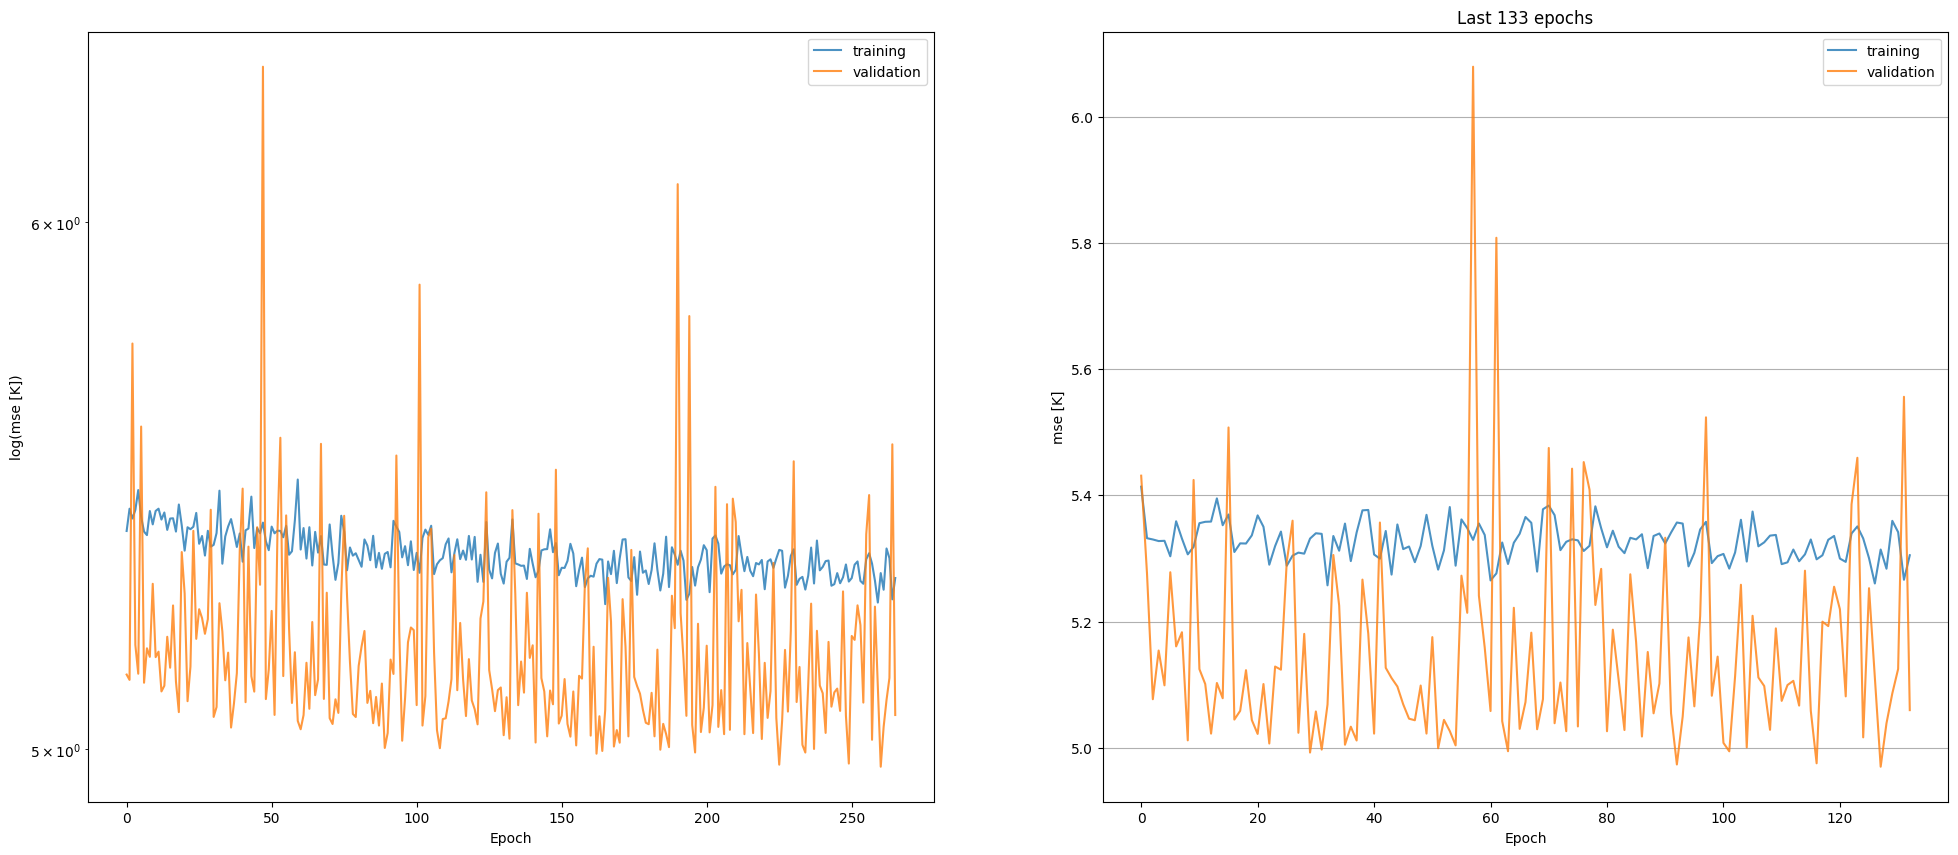

In [75]:
plot_history(history.history)

In [74]:
model_path = "../../models/local_winsat_emiss_8.keras"
save_model(model, model_path)

# Save the training history:
history_path = "../../models/local_winsat_emiss_8_history"
with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)